<a href="https://colab.research.google.com/github/arjunprithvi3/demo1/blob/main/Copy_of_CDP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install --upgrade tensorflow==2.15.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

Original model input shape: (None, 28)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn (RNN)                   (None, 150)               26850     
                                                                 
 dropout (Dropout)           (None, 150)               0         
                                                                 
 dense (Dense)               (None, 64)                9664      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 36579 (142.89 KB)
Trainable params: 36579 (142.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


[*********************100%%**********************]  1 of 1 completed


Training data shape: (2896, 10, 28)
Testing data shape: (725, 10, 28)
Epoch 1/900
91/91 [==============================] - 3s 12ms/step - loss: 0.0868 - val_loss: 0.0239
Epoch 2/900
91/91 [==============================] - 1s 9ms/step - loss: 0.0250 - val_loss: 0.0212
Epoch 3/900
91/91 [==============================] - 1s 9ms/step - loss: 0.0209 - val_loss: 0.0217
Epoch 4/900
91/91 [==============================] - 1s 8ms/step - loss: 0.0196 - val_loss: 0.0183
Epoch 5/900
91/91 [==============================] - 1s 9ms/step - loss: 0.0184 - val_loss: 0.0190
Epoch 6/900
91/91 [==============================] - 1s 8ms/step - loss: 0.0178 - val_loss: 0.0173
Epoch 7/900
91/91 [==============================] - 1s 9ms/step - loss: 0.0171 - val_loss: 0.0167
Epoch 8/900
91/91 [==============================] - 1s 8ms/step - loss: 0.0165 - val_loss: 0.0165
Epoch 9/900
91/91 [==============================] - 1s 9ms/step - loss: 0.0160 - val_loss: 0.0159
Epoch 10/900
91/91 [==================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


23/23 [==============================] - 0s 3ms/step
Test Loss (MSE): 0.0005
Mean Squared Error (MSE): 0.0000
Root Mean Squared Error (RMSE): 0.0062
Mean Absolute Error (MAE): 0.0053


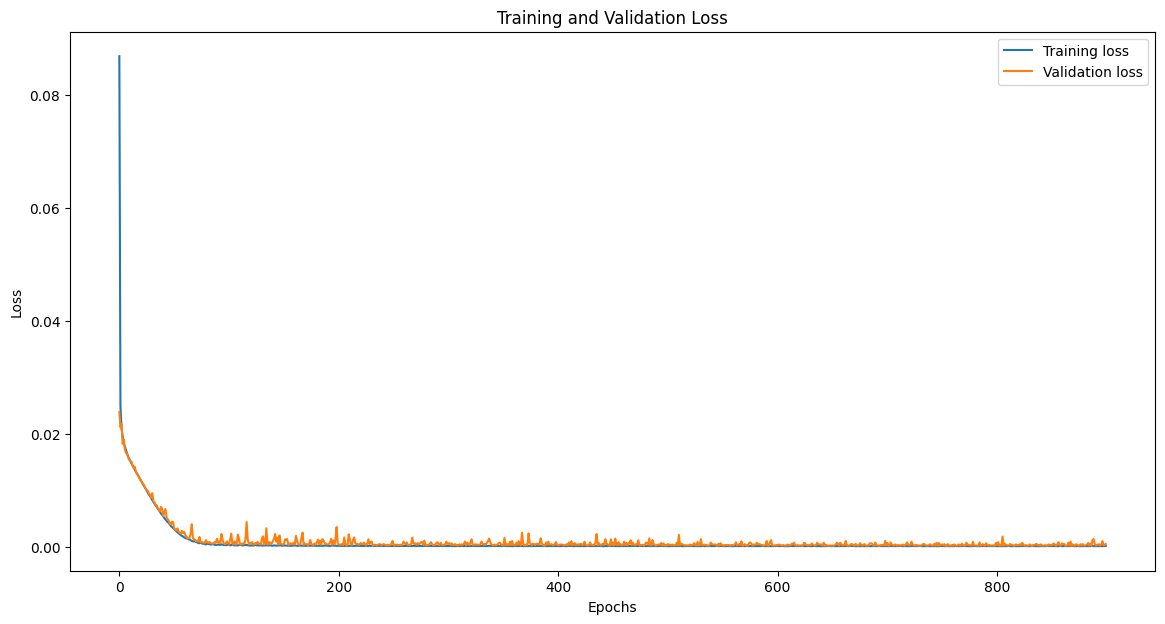

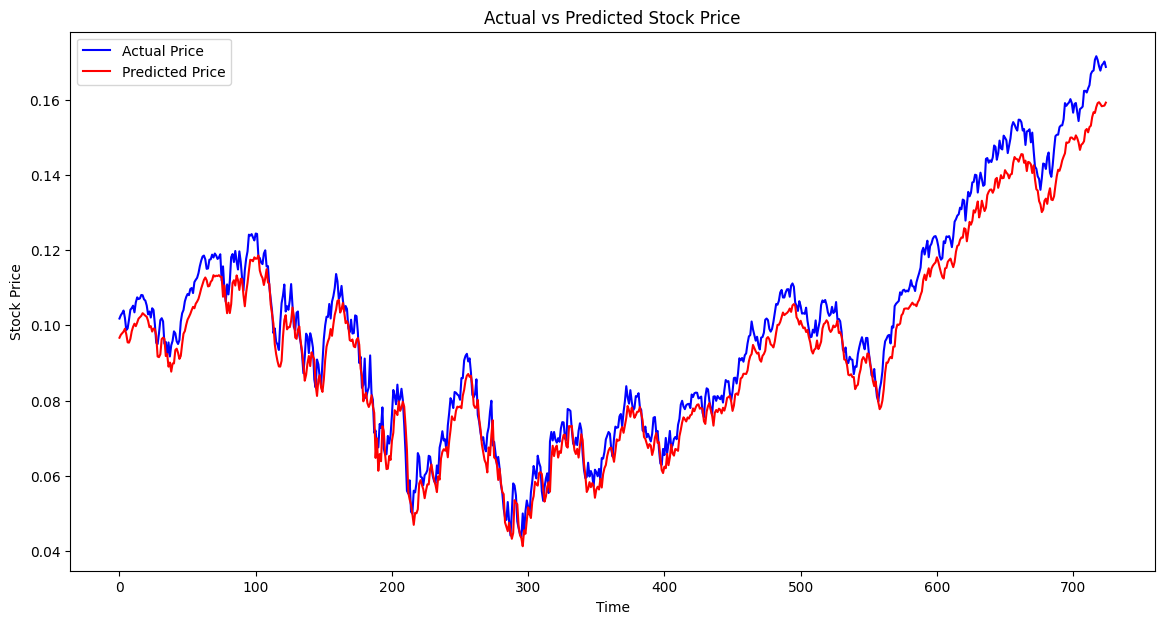

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Dropout, RNN
from keras.regularizers import L1L2
from keras.initializers import GlorotUniform, Zeros

from enum import Enum
import matplotlib.pyplot as plt
from flask import Flask, request, jsonify

# Custom layers/classes as defined in app.py
class MappingType(Enum):
    Identity = 0
    Linear = 1
    Affine = 2

class ODESolver(Enum):
    SemiImplicit = 0
    Explicit = 1
    RungeKutta = 2

class LTCCell(tf.keras.layers.AbstractRNNCell):
    def __init__(self, num_units, input_mapping=MappingType.Affine, solver=ODESolver.SemiImplicit,
                 ode_solver_unfolds=6, activation=tf.nn.tanh, **kwargs):
        super().__init__(**kwargs)
        self._num_units = num_units
        self._ode_solver_unfolds = ode_solver_unfolds
        self._solver = solver
        self._input_mapping = input_mapping
        self._activation = activation

    @property
    def state_size(self):
        return self._num_units

    @property
    def output_size(self):
        return self._num_units

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self._num_units), initializer='glorot_uniform', name='kernel')
        self.recurrent_kernel = self.add_weight(shape=(self._num_units, self._num_units), initializer='glorot_uniform', name='recurrent_kernel')
        self.bias = self.add_weight(shape=(self._num_units,), initializer='zeros', name='bias')
        self.built = True

    def call(self, inputs, states):
        prev_output = states[0]
        net_input = tf.matmul(inputs, self.kernel)
        net_input += tf.matmul(prev_output, self.recurrent_kernel)
        net_input += self.bias
        output = self._activation(net_input)

        return output, [output]

    def get_config(self):
        config = super(LTCCell, self).get_config()
        config.update({"num_units": self._num_units})
        return config

class CTRNN(tf.keras.layers.AbstractRNNCell):
    def __init__(self, units, global_feedback=False, activation=tf.nn.tanh, cell_clip=None, **kwargs):
        self.units = units
        self.global_feedback = global_feedback
        self.activation = activation
        self.cell_clip = cell_clip
        super(CTRNN, self).__init__(**kwargs)

    @property
    def state_size(self):
        return self.units

    @property
    def output_size(self):
        return self.units

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units), initializer='glorot_uniform', name='kernel')
        self.recurrent_kernel = self.add_weight(shape=(self.units, self.units), initializer='glorot_uniform', name='recurrent_kernel')
        self.bias = self.add_weight(shape=(self.units,), initializer='zeros', name='bias')
        self.built = True

    def call(self, inputs, states):
        prev_output = states[0]
        net_input = tf.matmul(inputs, self.kernel)
        net_input += tf.matmul(prev_output, self.recurrent_kernel)
        net_input += self.bias
        output = self.activation(net_input)

        if self.cell_clip is not None:
            output = tf.clip_by_value(output, -self.cell_clip, self.cell_clip)

        return output, [output]

class NODE(tf.keras.layers.AbstractRNNCell):
    def __init__(self, units, cell_clip=None, **kwargs):
        self.units = units
        self.cell_clip = cell_clip
        super(NODE, self).__init__(**kwargs)

    @property
    def state_size(self):
        return self.units

    @property
    def output_size(self):
        return self.units

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units), initializer='glorot_uniform', name='kernel')
        self.recurrent_kernel = self.add_weight(shape=(self.units, self.units), initializer='glorot_uniform', name='recurrent_kernel')
        self.bias = self.add_weight(shape=(self.units,), initializer='zeros', name='bias')
        self.built = True

    def call(self, inputs, states):
        prev_output = states[0]
        net_input = tf.matmul(inputs, self.kernel)
        net_input += tf.matmul(prev_output, self.recurrent_kernel)
        net_input += self.bias
        output = tf.nn.tanh(net_input)

        if self.cell_clip is not None:
            output = tf.clip_by_value(output, -self.cell_clip, self.cell_clip)

        return output, [output]

class CTGRU(tf.keras.layers.AbstractRNNCell):
    def __init__(self, units, cell_clip=None, **kwargs):
        self.units = units
        self.cell_clip = cell_clip
        super(CTGRU, self).__init__(**kwargs)

    @property
    def state_size(self):
        return self.units

    @property
    def output_size(self):
        return self.units

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], 2 * self.units), initializer='glorot_uniform', name='kernel')
        self.recurrent_kernel = self.add_weight(shape=(self.units, 2 * self.units), initializer='glorot_uniform', name='recurrent_kernel')
        self.bias = self.add_weight(shape=(2 * self.units,), initializer='zeros', name='bias')
        self.kernel_c = self.add_weight(shape=(input_shape[-1], self.units), initializer='glorot_uniform', name='kernel_c')
        self.recurrent_kernel_c = self.add_weight(shape=(self.units, self.units), initializer='glorot_uniform', name='recurrent_kernel_c')
        self.bias_c = self.add_weight(shape=(self.units,), initializer='zeros', name='bias_c')
        self.built = True

    def call(self, inputs, states):
        prev_output = states[0]
        zr = tf.matmul(inputs, self.kernel)
        zr += tf.matmul(prev_output, self.recurrent_kernel)
        zr += self.bias
        z, r = tf.split(zr, 2, axis=-1)

        z = tf.sigmoid(z)
        r = tf.sigmoid(r)

        c = tf.matmul(inputs, self.kernel_c)
        c += r * tf.matmul(prev_output, self.recurrent_kernel_c)
        c += self.bias_c
        c = tf.nn.tanh(c)

        output = (1 - z) * prev_output + z * c

        if self.cell_clip is not None:
            output = tf.clip_by_value(output, -self.cell_clip, self.cell_clip)

        return output, [output]

input_dim = 28  # Assuming the input_dim is known

# Define the model architecture
model = Sequential()
# Add the RNN layer with LTCCell
model.add(RNN(LTCCell(num_units=150), input_shape=(None, input_dim), name='rnn'))
# Add Dropout layer
model.add(Dropout(rate=0.2, name='dropout'))
# Add Dense layer with L1 and L2 regularizers
model.add(Dense(
    units=64,
    activation='linear',
    kernel_initializer=GlorotUniform(),
    bias_initializer=Zeros(),
    kernel_regularizer=L1L2(l1=9.999999747378752e-06, l2=9.999999747378752e-05),
    bias_regularizer=L1L2(l2=9.999999747378752e-06),
    activity_regularizer=L1L2(l1=9.999999747378752e-05),
    name='dense'
))
# Add final Dense layer
model.add(Dense(
    units=1,
    activation='linear',
    kernel_initializer=GlorotUniform(),
    bias_initializer=Zeros(),
    name='dense_1'
))

# Compile the new model
model.compile(optimizer='adam', loss='mean_squared_error')

# Inspect the input shape of the original model
original_input_shape = model.input_shape[1:]  # Excluding batch size
print(f"Original model input shape: {original_input_shape}")

# Print model summary to verify
model.summary()

# Download SPY data
data = yf.download('SPY', start='2010-01-01', end='2024-07-01')
# data.to_csv(f"data.csv")

# Feature engineering function
def feature_engineering(data):
       # Check if data is valid and has sufficient length
    if data is None or data.empty or len(data) < 15:
        raise ValueError("Insufficient data for feature engineering")

    data['MACD_14_21_9'], data['MACDs_14_21_9'], data['MACDh_14_21_9'] = macd(data['Close'], fast=14, slow=21, signal=9)
    data['Daily Returns'] = data['Close'].pct_change()
    data['5-Day Momentum'] = data['Close'].diff(5)
    data['14-Day ATR'] = atr(data)
    data['14-Day SMA'] = data['Close'].rolling(window=14).mean()
    data['14-Day EMA'] = data['Close'].ewm(span=14, adjust=False).mean()
    data['14-Day RSI'] = rsi(data['Close'], window=14)
    data['BBL_14_2.0'], data['BBM_14_2.0'], data['BBU_14_2.0'] = bollinger_bands(data['Close'], window=14, num_std=2)
    data['BBB_14_2.0'] = data['BBU_14_2.0'] - data['BBL_14_2.0']
    data['BBP_14_2.0'] = (data['Close'] - data['BBL_14_2.0']) / (data['BBU_14_2.0'] - data['BBL_14_2.0'])
    data['OBV'] = obv(data)
    data['STOCHk_14_3_3'], data['STOCHd_14_3_3'] = stochastic_oscillator(data, window=14)
    data['STOCHk_3_3_3'], data['STOCHd_3_3_3'] = stochastic_oscillator(data, window=3)
    data['Fib 38.2%'] = data['Close'].rolling(window=14).apply(lambda x: np.percentile(x, 38.2))
    data['Fib 50%'] = data['Close'].rolling(window=14).apply(lambda x: np.percentile(x, 50))
    data['Fib 61.8%'] = data['Close'].rolling(window=14).apply(lambda x: np.percentile(x, 61.8))
    data['3 Day ROC'] = roc(data['Close'], window=3)
    return data

# Indicator functions
def rsi(series, window):
    delta = series.diff().dropna()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def macd(series, fast=12, slow=26, signal=9):
    fast_ema = series.ewm(span=fast, adjust=False).mean()
    slow_ema = series.ewm(span=slow, adjust=False).mean()
    macd = fast_ema - slow_ema
    signal = macd.ewm(span=signal, adjust=False).mean()
    hist = macd - signal
    return macd, signal, hist

def atr(data, window=14):
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift())
    low_close = np.abs(data['Low'] - data['Close'].shift())
    tr = high_low.combine(high_close, max).combine(low_close, max)
    return tr.rolling(window=window, min_periods=1).mean()

def bollinger_bands(series, window, num_std=2):
    sma = series.rolling(window).mean()
    std = series.rolling(window).std()
    upper_band = sma + num_std * std
    lower_band = sma - num_std * std
    return lower_band, sma, upper_band

def obv(data):
    obv = (np.sign(data['Close'].diff()) * data['Volume']).fillna(0).cumsum()
    return obv

def stochastic_oscillator(data, window=14, smooth_window=3):
    low_min = data['Low'].rolling(window).min()
    high_max = data['High'].rolling(window).max()
    k = 100 * (data['Close'] - low_min) / (high_max - low_min)
    d = k.rolling(smooth_window).mean()
    return k, d

def roc(series, window):
    return series.diff(window) / series.shift(window)

# Apply feature engineering
data = feature_engineering(data)
data.dropna(inplace=True)
# data.to_csv(f"data.csv")

# Preprocess the data
total_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'MACD_14_21_9', 'MACDh_14_21_9', 'MACDs_14_21_9', 'Daily Returns',
                  '5-Day Momentum', '14-Day ATR', '14-Day SMA', '14-Day EMA', '14-Day RSI', 'BBL_14_2.0', 'BBM_14_2.0',
                  'BBU_14_2.0', 'BBB_14_2.0', 'BBP_14_2.0', 'OBV', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'STOCHk_3_3_3',
                  'STOCHd_3_3_3', 'Fib 38.2%', 'Fib 50%', 'Fib 61.8%', '3 Day ROC']
data = data[total_features]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        seq = data[i-seq_length:i]
        X.append(seq)
        y.append(data[i, 3])  # 'Close' is the target variable, which is at index 3 in the total_features list
    return np.array(X), np.array(y)

SEQ_LENGTH = 10  # Look-back period
NUM_FEATURES = len(total_features)

# Generate sequences with the additional features
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split the data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Train the new model with the SPY data
# model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

# Training the model and capturing the history
history = model.fit(X_train, y_train, epochs=900, batch_size=32, validation_data=(X_test, y_test))

# Save the new model
model.save('spy_model.h5')

# Evaluate the model
test_loss = model.evaluate(X_test, y_test, verbose=0)
Y_pred = model.predict(X_test)

# Inverse transform the predictions and true values to get the actual values
y_test_actual = scaler.inverse_transform(np.c_[np.zeros((len(y_test), NUM_FEATURES-1)), y_test])[:, -1]
Y_pred_actual = scaler.inverse_transform(np.c_[np.zeros((len(Y_pred), NUM_FEATURES-1)), Y_pred])[:, -1]

# Calculate metrics
mse = mean_squared_error(y_test_actual, Y_pred_actual)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, Y_pred_actual)

print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Plotting the training and validation loss
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot the actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, color='blue', label='Actual Price')
plt.plot(Y_pred_actual, color='red', label='Predicted Price')
plt.title('Actual vs Predicted Stock Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

